# First Objective: "Velocity Packet Tracker Visualisation" & "Develop an interactive abundance visualization tool"

This notebook contains the solution to the first objective of the "Velocity Packet Tracker Visualisation" as mentioned in [the GSoC'23 ideas page](https://tardis-sn.github.io/gsoc_2023/ideas/).

First we download the atom data and run a tardis simulation from the [tardis_example.yml](https://github.com/tardis-sn/tardis/blob/master/docs/tardis_example.yml) file.

In [1]:
# Download the atomic data
from tardis.io.atom_data.util import download_atom_data
download_atom_data('kurucz_cd23_chianti_H_He')


Iterations:          0/? [00:00<?, ?it/s]

Packets:             0/? [00:00<?, ?it/s]

In [2]:
from tardis import run_tardis

sim = run_tardis('tardis_example.yml', virtual_packet_logging=True)

[tardis.plasma.standard_plasmas][INFO   ]  
	
	Reading Atomic Data from kurucz_cd23_chianti_H_He.h5 (standard_plasmas.py:95)
[tardis.io.atom_data.util][INFO   ]  
	
	Atom Data kurucz_cd23_chianti_H_He.h5 not found in local path.
	Exists in TARDIS Data repo /Users/archil/Downloads/tardis-data/kurucz_cd23_chianti_H_He.h5 (util.py:33)
[tardis.io.atom_data.base][INFO   ]  
	Reading Atom Data with: UUID = 6f7b09e887a311e7a06b246e96350010 MD5  = 864f1753714343c41f99cb065710cace  (base.py:249)
[tardis.io.atom_data.base][INFO   ]  
	Non provided Atomic Data: synpp_refs, photoionization_data, yg_data, two_photon_data (base.py:253)
[py.warnings         ][WARNING]  
	/Users/archil/Documents/tardis/tardis/plasma/properties/radiative_properties.py:93: RuntimeWarning: invalid value encountered in true_divide
  (g_lower * n_upper) / (g_upper * n_lower)
 (warnings.py:109)


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


[py.warnings         ][WARNING]  
	/Users/archil/Documents/tardis/tardis/plasma/properties/radiative_properties.py:93: RuntimeWarning: invalid value encountered in true_divide
  (g_lower * n_upper) / (g_upper * n_lower)
 (warnings.py:109)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 1 of 20 (base.py:385)


TqdmHBox(children=(HTML(value='Iterations:', layout=Layout(width='6%')), FloatProgress(value=0.0, layout=Layou…

TqdmHBox(children=(HTML(value='Packets:   ', layout=Layout(width='6%')), FloatProgress(value=0.0, layout=Layou…

[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 7.942e+42 erg / s
	Luminosity absorbed  = 2.659e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,9.93e+03,1.01e+04,0.4,0.507
5,9.85e+03,1.02e+04,0.211,0.197
10,9.78e+03,1.01e+04,0.143,0.117
15,9.71e+03,9.87e+03,0.105,0.0869


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 9933.952 K
	Expected t_inner for next iteration = 10703.212 K
 (base.py:554)
[py.warnings         ][WARNING]  
	/Users/archil/Documents/tardis/tardis/plasma/properties/radiative_properties.py:93: RuntimeWarning: invalid value encountered in true_divide
  (g_lower * n_upper) / (g_upper * n_lower)
 (warnings.py:109)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 2 of 20 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.071e+43 erg / s
	Luminosity absorbed  = 3.576e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.01e+04,1.08e+04,0.507,0.525
5,1.02e+04,1.1e+04,0.197,0.203
10,1.01e+04,1.08e+04,0.117,0.125
15,9.87e+03,1.05e+04,0.0869,0.0933


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10703.212 K
	Expected t_inner for next iteration = 10673.712 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 3 of 20 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.074e+43 erg / s
	Luminosity absorbed  = 3.391e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.08e+04,1.1e+04,0.525,0.483
5,1.1e+04,1.12e+04,0.203,0.189
10,1.08e+04,1.1e+04,0.125,0.118
15,1.05e+04,1.06e+04,0.0933,0.0895


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10673.712 K
	Expected t_inner for next iteration = 10635.953 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 4 of 20 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.058e+43 erg / s
	Luminosity absorbed  = 3.352e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.1e+04,1.1e+04,0.483,0.469
5,1.12e+04,1.12e+04,0.189,0.182
10,1.1e+04,1.1e+04,0.118,0.113
15,1.06e+04,1.07e+04,0.0895,0.0861


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10635.953 K
	Expected t_inner for next iteration = 10638.407 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 5 of 20 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.055e+43 erg / s
	Luminosity absorbed  = 3.399e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 1/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.1e+04,1.1e+04,0.469,0.479
5,1.12e+04,1.13e+04,0.182,0.178
10,1.1e+04,1.1e+04,0.113,0.113
15,1.07e+04,1.07e+04,0.0861,0.0839


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10638.407 K
	Expected t_inner for next iteration = 10650.202 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 6 of 20 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.061e+43 erg / s
	Luminosity absorbed  = 3.398e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 2/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.1e+04,1.1e+04,0.479,0.47
5,1.13e+04,1.12e+04,0.178,0.185
10,1.1e+04,1.11e+04,0.113,0.112
15,1.07e+04,1.07e+04,0.0839,0.0856


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10650.202 K
	Expected t_inner for next iteration = 10645.955 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 7 of 20 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.061e+43 erg / s
	Luminosity absorbed  = 3.382e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 3/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.1e+04,1.1e+04,0.47,0.47
5,1.12e+04,1.13e+04,0.185,0.178
10,1.11e+04,1.11e+04,0.112,0.112
15,1.07e+04,1.07e+04,0.0856,0.086


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10645.955 K
	Expected t_inner for next iteration = 10642.050 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 8 of 20 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.062e+43 erg / s
	Luminosity absorbed  = 3.350e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 4/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.1e+04,1.11e+04,0.47,0.472
5,1.13e+04,1.14e+04,0.178,0.175
10,1.11e+04,1.11e+04,0.112,0.111
15,1.07e+04,1.07e+04,0.086,0.084


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10642.050 K
	Expected t_inner for next iteration = 10636.106 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 9 of 20 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.052e+43 erg / s
	Luminosity absorbed  = 3.411e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 5/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.11e+04,1.11e+04,0.472,0.469
5,1.14e+04,1.15e+04,0.175,0.17
10,1.11e+04,1.11e+04,0.111,0.109
15,1.07e+04,1.08e+04,0.084,0.0822


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10636.106 K
	Expected t_inner for next iteration = 10654.313 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 10 of 20 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.070e+43 erg / s
	Luminosity absorbed  = 3.335e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.11e+04,1.1e+04,0.469,0.475
5,1.15e+04,1.14e+04,0.17,0.177
10,1.11e+04,1.11e+04,0.109,0.112
15,1.08e+04,1.06e+04,0.0822,0.0878


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10654.313 K
	Expected t_inner for next iteration = 10628.190 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 11 of 20 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.053e+43 erg / s
	Luminosity absorbed  = 3.363e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 1/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.1e+04,1.1e+04,0.475,0.472
5,1.14e+04,1.12e+04,0.177,0.184
10,1.11e+04,1.1e+04,0.112,0.114
15,1.06e+04,1.06e+04,0.0878,0.0859


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10628.190 K
	Expected t_inner for next iteration = 10644.054 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 12 of 20 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.056e+43 erg / s
	Luminosity absorbed  = 3.420e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.1e+04,1.11e+04,0.472,0.467
5,1.12e+04,1.13e+04,0.184,0.176
10,1.1e+04,1.11e+04,0.114,0.11
15,1.06e+04,1.08e+04,0.0859,0.0821


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10644.054 K
	Expected t_inner for next iteration = 10653.543 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 13 of 20 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.062e+43 erg / s
	Luminosity absorbed  = 3.406e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 1/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.11e+04,1.11e+04,0.467,0.466
5,1.13e+04,1.13e+04,0.176,0.18
10,1.11e+04,1.11e+04,0.11,0.111
15,1.08e+04,1.08e+04,0.0821,0.0841


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10653.543 K
	Expected t_inner for next iteration = 10647.277 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 14 of 20 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.063e+43 erg / s
	Luminosity absorbed  = 3.369e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 2/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.11e+04,1.11e+04,0.466,0.469
5,1.13e+04,1.13e+04,0.18,0.182
10,1.11e+04,1.1e+04,0.111,0.113
15,1.08e+04,1.07e+04,0.0841,0.0854


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10647.277 K
	Expected t_inner for next iteration = 10638.875 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 15 of 20 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.053e+43 erg / s
	Luminosity absorbed  = 3.417e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 3/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.11e+04,1.1e+04,0.469,0.484
5,1.13e+04,1.13e+04,0.182,0.181
10,1.1e+04,1.1e+04,0.113,0.113
15,1.07e+04,1.07e+04,0.0854,0.0858


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10638.875 K
	Expected t_inner for next iteration = 10655.125 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 16 of 20 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.059e+43 erg / s
	Luminosity absorbed  = 3.445e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 4/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.1e+04,1.1e+04,0.484,0.472
5,1.13e+04,1.13e+04,0.181,0.177
10,1.1e+04,1.1e+04,0.113,0.113
15,1.07e+04,1.06e+04,0.0858,0.0858


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10655.125 K
	Expected t_inner for next iteration = 10655.561 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 17 of 20 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.067e+43 erg / s
	Luminosity absorbed  = 3.372e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.1e+04,1.11e+04,0.472,0.468
5,1.13e+04,1.14e+04,0.177,0.175
10,1.1e+04,1.11e+04,0.113,0.11
15,1.06e+04,1.08e+04,0.0858,0.0816


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10655.561 K
	Expected t_inner for next iteration = 10636.536 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 18 of 20 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.057e+43 erg / s
	Luminosity absorbed  = 3.365e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 1/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.11e+04,1.11e+04,0.468,0.464
5,1.14e+04,1.13e+04,0.175,0.177
10,1.11e+04,1.1e+04,0.11,0.113
15,1.08e+04,1.07e+04,0.0816,0.0848


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10636.536 K
	Expected t_inner for next iteration = 10641.692 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 19 of 20 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.056e+43 erg / s
	Luminosity absorbed  = 3.405e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 2/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.11e+04,1.11e+04,0.464,0.466
5,1.13e+04,1.13e+04,0.177,0.177
10,1.1e+04,1.11e+04,0.113,0.111
15,1.07e+04,1.07e+04,0.0848,0.0853


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10641.692 K
	Expected t_inner for next iteration = 10650.463 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 20 of 20 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.061e+43 erg / s
	Luminosity absorbed  = 3.401e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Simulation finished in 20 iterations 
	Simulation took 36.49 s
 (base.py:480)


# SDEC Plot

In [3]:
from tardis.visualization import SDECPlotter
plotter = SDECPlotter.from_simulation(sim)

<AxesSubplot:xlabel='Wavelength $[\\mathrm{\\AA}]$', ylabel='$L_{\\lambda}$ [erg $\\mathrm{s^{-1}}$ $\\mathrm{\\AA^{-1}}$]'>

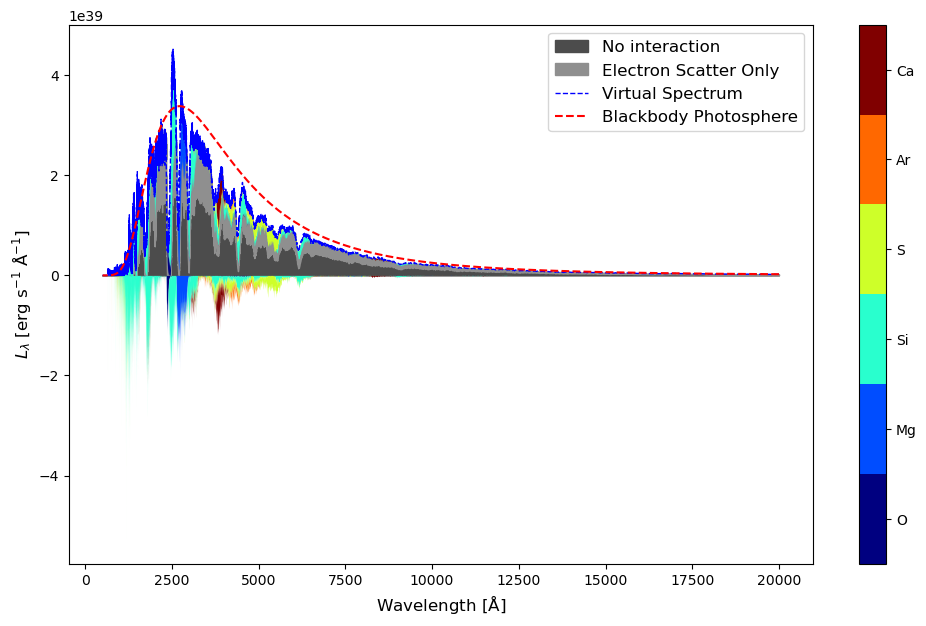

In [4]:
plotter.generate_plot_mpl()

# Abundance vs velocity

In [5]:
# Fetch velocities
shell_velocities = sim.model.v_inner.si
print(shell_velocities)

20
[11000000. 11450000. 11900000. 12350000. 12800000. 13250000. 13700000.
 14150000. 14600000. 15050000. 15500000. 15950000. 16400000. 16850000.
 17300000. 17750000. 18200000. 18650000. 19100000. 19550000.] m / s


In [38]:
# Fetch abundances
shell_abundances = sim.plasma.abundance
shell_abundances

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
atomic_number,,,,,,,,,,,,,,,,,,,,
8,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19
12,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03
14,0.52,0.52,0.52,0.52,0.52,0.52,0.52,0.52,0.52,0.52,0.52,0.52,0.52,0.52,0.52,0.52,0.52,0.52,0.52,0.52
16,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19
18,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04
20,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03


In [43]:
# Fetch shell densities
shell_densities = sim.model.homologous_density.density_0.si
print(shell_densities)

[1.97052717e+06 1.33603184e+04 1.01466582e+04 7.78662077e+03
 6.03344417e+03 4.71712224e+03 3.71894570e+03 2.95498192e+03
 2.36519135e+03 1.90615556e+03 1.54615391e+03 1.26178882e+03
 1.03564575e+03 8.54652716e+02 7.08918432e+02 5.90901467e+02
 4.94810562e+02 4.16168092e+02 3.51489643e+02 2.98046988e+02
 2.53691438e+02] kg / m3


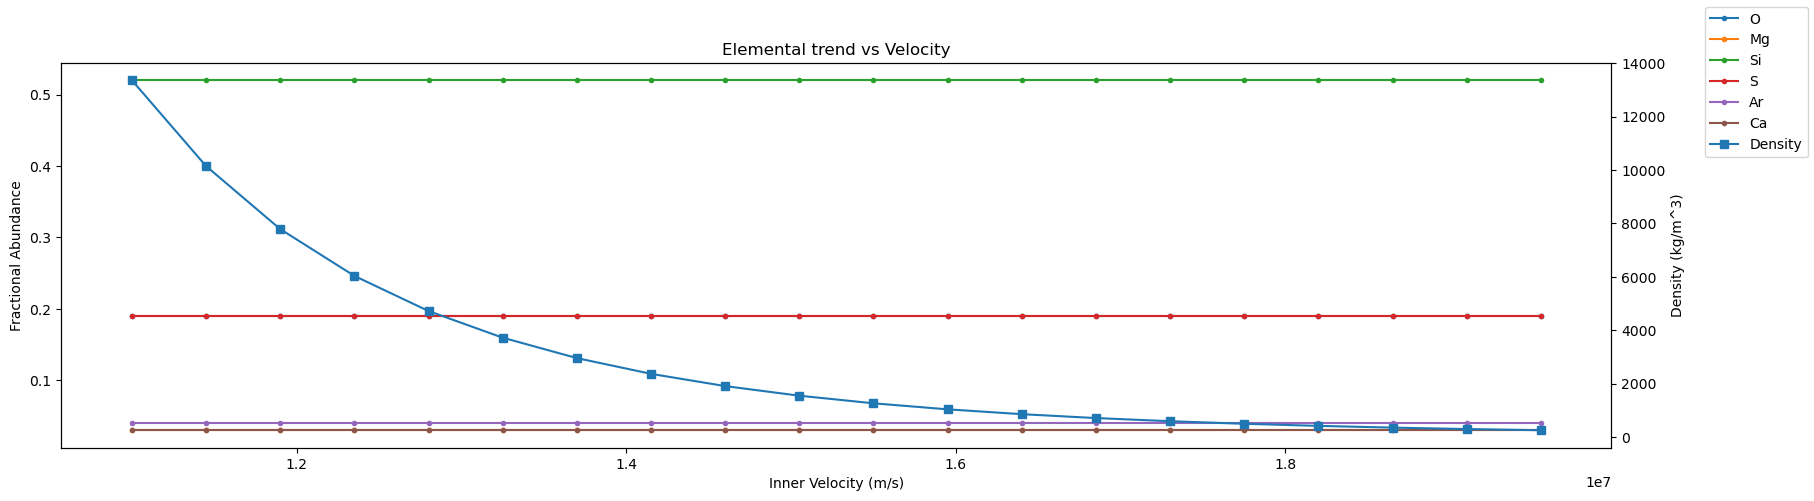

In [44]:
import matplotlib.pyplot as plt

# Plot fractional abudances
fig, abundance_axis = plt.subplots(figsize=(20, 5))

atom_data = sim.plasma.atomic_data.atom_data

for atomic_number in sim.plasma.selected_atoms:
    atom_abundance = shell_abundances.loc[atomic_number]
    abundance_axis.plot(shell_velocities, atom_abundance, marker='.', label=atom_data.symbol.loc[atomic_number])

abundance_axis.set(title='Elemental trend vs Velocity', xlabel='Inner Velocity (m/s)', ylabel='Fractional Abundance')

density_axis = abundance_axis.twinx()
density_axis.plot(shell_velocities, shell_densities[1:], marker='s', label='Density')
density_axis.set(ylabel='Density (kg/m^3)')

_ = fig.legend()